In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [13]:
module = fc.eightb.preselection.t8btag_minmass
dout = "particle_net"

In [5]:
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False, altfile='particle_net_{base}') for f in tqdm(module.signal_list) ])
# signal = ObjIter([ Tree(f, report=False, altfile='particle_net_{base}') for f in tqdm(module.full_signal_list) ])

bkg = ObjIter([])
# bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List, altfile='particle_net_{base}'), Tree(module.Run2_UL18.TTJets, altfile='particle_net_{base}')])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List, altfile='particle_net_{base}') ])

100%|██████████| 3/3 [00:11<00:00,  3.75s/it]


100%|██████████| 2/2 [00:00<00:00,  8.96it/s]


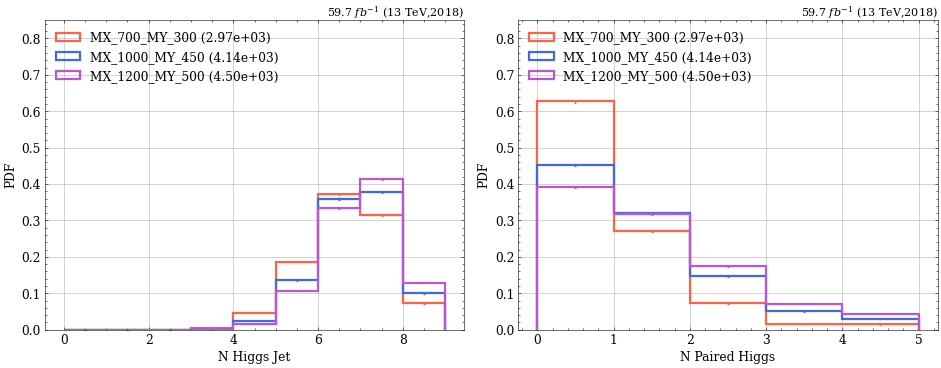

In [14]:
study.quick( 
    signal,
    legend=True,
    varlist=['nfound_select','nfound_paired_h'],
    xlabels=['N Higgs Jet','N Paired Higgs'],
    efficiency=True, ylim=(0,0.85), grid=True,
    saveas=f'{dout}/signal_n_reco'
)

100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


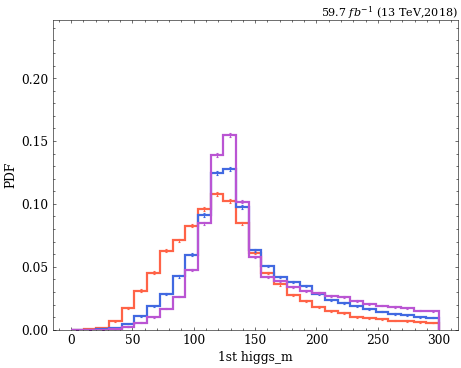

In [11]:
study.quick( 
    signal,
    efficiency=True,
    varlist=['higgs_m[:,0]'],
    binlist=[(0,300,30)]
)

In [6]:
# bkg.reweight(2.3)
# bkg.set_systematics(0.2)

In [7]:
def n_presel_jets(t):
    t.extend(n_presel_jet=t.n_jet)
(signal+bkg+data).apply(n_presel_jets)

[None, None, None, None, None, None, None, None, None, None, None]

In [8]:
# (signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='pt'), report=True)
t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)
signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)
data = data.apply(t8btag)

In [9]:
path = f"/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker/20221115_ranger_lr0.0047_batch512_m7m10m12/"


In [11]:
(signal+bkg+data).apply(lambda t : eightb.load_quadh(t, path), report=True)
# (signal).apply(lambda t : eightb.load_quadh(t, path), report=True)


100%|██████████| 11/11 [00:32<00:00,  2.96s/it]


[None, None, None, None, None, None, None, None, None, None, None]

In [12]:
# event_filter = FilterSequence(
#     eightb.selected_jet_ptregressed(),
#     eightb.selected_jet_btagwp()
# )

# signal = signal.apply(event_filter)
# bkg = bkg.apply(event_filter)
# data = data.apply(event_filter)

In [13]:
def nfound_higgs(t):
    nhiggs = ak.sum(t.higgs_signalId>-1,axis=-1)
    t.extend(nfound_paired_h=nhiggs)
signal.apply(nfound_higgs)

[None, None, None, None, None, None, None, None]

In [14]:
(signal+bkg+data).apply(lambda t : eightb.pair_y_from_higgs(t, operator=eightb.y_min_mass_asym), report=True)

100%|██████████| 11/11 [00:27<00:00,  2.49s/it]


[None, None, None, None, None, None, None, None, None, None, None]

In [15]:
def build_bdt_features(t):
    jet_ht = ak.sum(t.jet_ptRegressed,axis=-1)

    j1_phi, j2_phi = ak.unzip(ak.combinations(t.jet_phi, n=2, axis=-1))
    jet_dphi = calc_dphi(j1_phi, j2_phi)

    j1_eta, j2_eta = ak.unzip(ak.combinations(t.jet_eta, n=2, axis=-1))
    jet_deta = calc_deta(j1_eta, j2_eta)

    min_jet_deta = ak.min( np.abs(jet_deta), axis=-1)
    max_jet_deta = ak.max( np.abs(jet_deta), axis=-1)

    jet_dr = np.sqrt( jet_deta**2 + jet_dphi**2 )

    min_jet_dr = ak.min(jet_dr, axis=-1)
    max_jet_dr = ak.max(jet_dr, axis=-1)

    h1_phi, h2_phi = ak.unzip(ak.combinations(t.higgs_phi, n=2, axis=-1))
    higgs_dphi = np.abs(calc_dphi(h1_phi, h2_phi))

    h1_eta, h2_eta = ak.unzip(ak.combinations(t.higgs_eta, n=2, axis=-1))
    higgs_deta = np.abs(calc_deta(h1_eta, h2_eta))

    higgs_comb_id = ak.combinations( np.arange(4), n=2, axis=0).tolist()

    t.extend(
        jet_ht=jet_ht,
        min_jet_deta=min_jet_deta,
        max_jet_deta=max_jet_deta,
        min_jet_dr=min_jet_dr,
        max_jet_dr=max_jet_dr,
        **{
            f'h{i+1}{j+1}_dphi':higgs_dphi[:,k]
            for k, (i,j) in enumerate(higgs_comb_id)
        },
        **{
            f'h{i+1}{j+1}_deta':higgs_deta[:,k]
            for k, (i,j) in enumerate(higgs_comb_id)
        },
        **{
            f'h{i+1}_{var}':t[f'higgs_{var}'][:,i]
            for i in range(4)
            for var in ('pt','dr')
        },
    )
(signal+bkg+data).apply(build_bdt_features, report=True)

100%|██████████| 11/11 [00:21<00:00,  1.99s/it]


[None, None, None, None, None, None, None, None, None, None, None]

In [16]:
(signal+bkg+data).write(
    f"{dout}_{{base}}"
)

Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_700_MY_300/ranked_quadh_ntuple.root


[65.11MB/65.11MB][100%][==================================================][65.11MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_800_MY_300/ranked_quadh_ntuple.root


[75.88MB/75.88MB][100%][==================================================][75.88MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_800_MY_350/ranked_quadh_ntuple.root


[77.65MB/77.65MB][100%][==================================================][77.65MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_900_MY_300/ranked_quadh_ntuple.root


[79.62MB/79.62MB][100%][==================================================][79.62MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_900_MY_400/ranked_quadh_ntuple.root


[85.74MB/85.74MB][100%][==================================================][42.87MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_1000_MY_300/ranked_quadh_ntuple.root


[81.48MB/81.48MB][100%][==================================================][81.48MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_1000_MY_450/ranked_quadh_ntuple.root


[91.67MB/91.67MB][100%][==================================================][91.67MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_1200_MY_500/ranked_quadh_ntuple.root


[99.44MB/99.44MB][100%][==================================================][99.44MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT100to200_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[270.2kB/270.2kB][100%][==================================================][270.2kB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT200to300_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[315.5kB/315.5kB][100%][==================================================][315.5kB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT300to500_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[1.754MB/1.754MB][100%][==================================================][1.754MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT500to700_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[12.14MB/12.14MB][100%][==================================================][12.14MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT700to1000_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[6.738MB/6.738MB][100%][==================================================][6.738MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[10.13MB/10.13MB][100%][==================================================][10.13MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT1500to2000_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[17.32MB/17.32MB][100%][==================================================][17.32MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT2000toInf_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[18.68MB/18.68MB][100%][==================================================][18.68MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT100to200_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[272.1kB/272.1kB][100%][==================================================][272.1kB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT200to300_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[286.7kB/286.7kB][100%][==================================================][286.7kB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT300to500_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[1.274MB/1.274MB][100%][==================================================][1.274MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT500to700_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[6.563MB/6.563MB][100%][==================================================][6.563MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT700to1000_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[11.19MB/11.19MB][100%][==================================================][11.19MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT1000to1500_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[8.523MB/8.523MB][100%][==================================================][8.523MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT1500to2000_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[11.55MB/11.55MB][100%][==================================================][11.55MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT2000toInf_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/ranked_quadh_ntuple.root


[13.85MB/13.85MB][100%][==================================================][13.85MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/TTJets/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/ranked_quadh_ntuple_0.root


[327.9MB/327.9MB][100%][==================================================][81.97MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/JetHT_Data/JetHT_Run2018A/ranked_quadh_ntuple.root


[705.7MB/705.7MB][100%][==================================================][88.22MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/JetHT_Data/JetHT_Run2018B/ranked_quadh_ntuple.root


[317.7MB/317.7MB][100%][==================================================][79.42MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/JetHT_Data/JetHT_Run2018C/ranked_quadh_ntuple.root


[277.7MB/277.7MB][100%][==================================================][92.57MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/JetHT_Data/JetHT_Run2018D/ranked_quadh_ntuple.root


[1.141GB/1.141GB][100%][==================================================][89.89MB/s]  


[None, None, None, None, None, None, None, None, None, None, None]